<a href="https://colab.research.google.com/github/VAllicar/Computational-Neuroscience-project-/blob/main/Final_code_paper9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    import brian2
except ImportError:
    !pip install brian2

from brian2 import *
prefs.codegen.target = 'numpy'
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
start_scope()

# Network parameters
N_network = 250
Input = 1000

# Neuron model equations
eqs_network_neuron = '''
dv/dt = (V_rest - v + g_ex*(E_ex - v))/tau_m : volt
dg_ex/dt = -g_ex/tau_ex : 1
'''
# LIF model parameters
tau_m = 20*ms
V_rest = -74*mV
V_reset = -60*mV
V_thresh = -54*mV
E_ex = 0*mV
tau_ex = 5*ms
gmax = 0.02  # Max synaptic conductance

In [ ]:
np.random.seed(123)

def calculate_rates(s, a, base_rate=10, peak_rate=80, sigma=100):
    rate = base_rate + peak_rate * (np.exp(-(s - a)**2 / (2 * sigma**2)) +
                                    np.exp(-(s + 1000 - a)**2 / (2 * sigma**2)) +
                                    np.exp(-(s - 1000 - a)**2 / (2 * sigma**2)))
    return rate * Hz  # Ensures the returned value has units of Hz

# Parameters
mean_interval = 20 * ms
duration = 1 * second
simulation_dt = 1 * ms

# Initialize lists for stimulus presentations
stimulus_durations = []
stimulus_times = []
time = 0 * ms

# Generate stimulus presentations
while time < duration:
    next_duration = np.random.exponential(mean_interval / second) * second  # Correcting units for exponential
    if time + next_duration > duration:
        break
    stimulus_times.append(time)
    stimulus_durations.append(next_duration)
    time += next_duration

# Calculate the total duration of the simulation in timesteps
total_duration_timesteps = sum([int(duration/ms) for duration in stimulus_durations])
print(total_duration_timesteps)

# Initialize an adjusted_rate_array with the correct dimensions
adjusted_rate_array = np.zeros((Input, total_duration_timesteps))

# Generate stimulus locations for each duration
stimulus_locations = np.random.randint(1, Input + 1, size=len(stimulus_times))

# Fill in the adjusted_rate_array based on stimulus presentations
current_timestep = 0
for idx, duration in enumerate(stimulus_durations):
    stimulus_duration_timesteps = int(duration/ms)
    for a in range(Input):
        rates = calculate_rates(stimulus_locations[idx], a)
        adjusted_rate_array[a, current_timestep:current_timestep + stimulus_duration_timesteps] = rates
    current_timestep += stimulus_duration_timesteps

# Create a TimedArray to model the input for the duration of each stimulus
input_timed_array = TimedArray(adjusted_rate_array.T * Hz, dt=simulation_dt)

# Correct the duration for running the simulation
correct_duration = total_duration_timesteps * simulation_dt

# Convert each duration to the number of simulation timesteps (dt) it spans
dt_counts = [int((duration / simulation_dt)) for duration in stimulus_durations]
total_timesteps = sum(dt_counts) * simulation_dt

968


In [ ]:
# Durations of the stimulus presentations - Plotting

# Convert stimulus_durations to milliseconds for plotting
durations_ms = [float(d/ms) for d in stimulus_durations]

# Create a figure for the plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(durations_ms)), durations_ms, color='skyblue')
plt.title('Durations of Each Stimulus Presentation')
plt.xlabel('Stimulus Presentation Number')
plt.ylabel('Duration (ms)')
plt.show()



In [ ]:
# STDP synapse model B = A_ tau_ / (A+ tau+)
taupre = 20*ms
taupost = 20*ms
Apre = 0.001
Bff = 1.06
Bre = 1.04
Aplus = 0.001

# Define A_post for feedforward and recurrent connections
A_post_ff = -Apre * Bff
A_post_re = -Apre * Bre

#STDP synapse model for feedforward connections

eqs_stdp_ff = '''
w : 1
dapre/dt = -apre/taupre : 1 (event-driven)
dapost/dt = -apost/taupost : 1 (event-driven)
'''
on_pre_ff = '''
g_ex += w
apre += Aplus
w = clip(w + A_post_ff, 0, gmax)
'''
on_post_ff = '''
apost += Aplus
w = clip(w + Apre, 0, gmax)
'''

# STDP synapse model for recurrent connections
eqs_stdp_re = '''
w : 1
dapre/dt = -apre/taupre : 1 (event-driven)
dapost/dt = -apost/taupost : 1 (event-driven)
'''
on_pre_re = '''
g_ex += w
apre += Aplus
w = clip(w + apost, 0, gmax)
'''
on_post_re = '''
apost += Aplus
w = clip(w + apre, 0, gmax)
'''

In [ ]:
# Backround input
background_rate = 500*Hz  # Background firing rate
background_input = PoissonGroup(N_network, rates=background_rate)

# Neuron group definitions
network_neurons = NeuronGroup(N_network, eqs_network_neuron, threshold='v>V_thresh', reset='v=V_reset', method='euler')
input_neurons = PoissonGroup(Input, rates='input_timed_array(t, i)')

In [ ]:
from brian2 import Hz, second, TimedArray, PoissonGroup, NeuronGroup, run, ms

# Connect the background input to network neurons with fixed synaptic strength
background_synapses = Synapses(background_input, network_neurons, on_pre='g_ex += 0.116')
background_synapses.connect(j='i')  # Assuming one-to-one mapping for simplicity

# Define feedforward synapses with STDP
feedforward_synapses = Synapses(input_neurons, network_neurons,
                                model=eqs_stdp_ff,
                                on_pre=on_pre_ff,
                                on_post=on_post_ff)
feedforward_synapses.connect('(j<100 or j>=201)', p=0.2)  # Connect with a probability of 0.2, and disconnecting the network neurons 101-200 from the input neurons
feedforward_synapses.w = 'rand() * gmax'


In [ ]:
# Create the synapses for recurrent connections within the network
recurrent_synapses = Synapses(network_neurons, network_neurons,
                              model=eqs_stdp_re,
                              on_pre=on_pre_re,
                              on_post=on_post_re)
recurrent_synapses.connect('abs(i-j) <= 1 and i != j')  # Example pattern connections i-j but also j-i and neighbors
recurrent_synapses.w = '0*gmax'

net = Network(input_neurons, network_neurons, feedforward_synapses, background_input, background_synapses, recurrent_synapses)

input_spike_monitor = SpikeMonitor(input_neurons)
network_spike_monitor = SpikeMonitor(network_neurons)
weight_monitor = StateMonitor(feedforward_synapses, 'w', record=True)
weight_monitor2 = StateMonitor(recurrent_synapses, 'w', record=True)


In [ ]:
# Include the monitors in your network
net.add([input_spike_monitor, network_spike_monitor, weight_monitor, weight_monitor2])
net.run(total_timesteps)

WARNING    'rates' is an internal variable of group 'poissongroup_1', but also exists in the run namespace with the value 31.53816838 * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'rates' is an internal variable of group 'poissongroup', but also exists in the run namespace with the value 31.53816838 * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


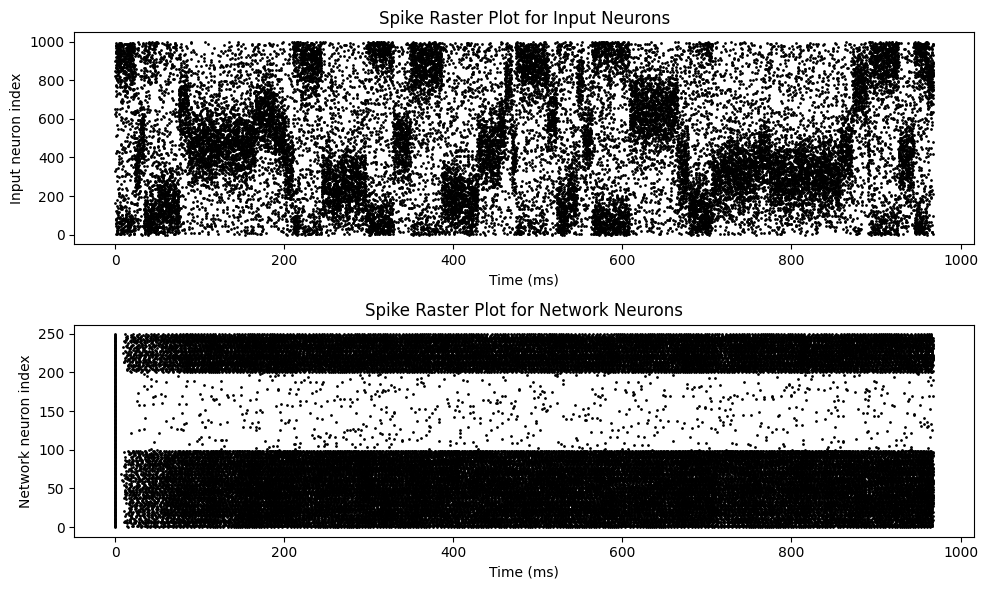

In [ ]:
# Plot input neuron spikes
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(input_spike_monitor.t/ms, input_spike_monitor.i, '.k', markersize=2)
plt.xlabel('Time (ms)')
plt.ylabel('Input neuron index')
plt.title('Spike Raster Plot for Input Neurons')

# Plot network neuron spikes
plt.subplot(212)
plt.plot(network_spike_monitor.t/ms, network_spike_monitor.i, '.k', markersize=2)
plt.xlabel('Time (ms)')
plt.ylabel('Network neuron index')
plt.title('Spike Raster Plot for Network Neurons')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

feedforward_final_weights = weight_monitor.w[:, -1]  # Get the final weights for all feedforward synapses
normalized_final_weights_f = feedforward_final_weights / gmax  # Normalize the weights

recurrent_final_weights = weight_monitor2.w[:, -1]  # Get the final weights for all recurrent synapses
normalized_final_weights_r = recurrent_final_weights / gmax  # Normalize the weights

# Initialize a matrix to hold the normalized synaptic weights (Input vs network)
normalized_weights_matrix_f = np.zeros((Input, N_network))

# Populate the matrix with the normalized synaptic weights
for idx in range(len(feedforward_synapses.i)):
    i = feedforward_synapses.i[idx]  # Input neuron index
    j = feedforward_synapses.j[idx]  # Network neuron index
    normalized_weights_matrix_f[i, j] = normalized_final_weights_f[idx]

# Initialize a matrix to hold the normalized synaptic weights (presynaptic vs postsynaptic)
normalized_weights_matrix_r = np.zeros((N_network, N_network))

# 'recurrent_final_weights' is a 1D array with the final weights for the recurrent synapses after STDP
for idx, weight in zip(range(len(recurrent_synapses.i)), recurrent_final_weights):
    pre_idx = recurrent_synapses.i[idx]  # Presynaptic neuron index
    post_idx = recurrent_synapses.j[idx]  # Postsynaptic neuron index
    normalized_weights_matrix_r[pre_idx, post_idx] = normalized_final_weights_r[idx]


In [ ]:
#Plotting figure 5A

# Gather the final synaptic weights for feedforward connections
final_weights_ff = weight_monitor.w[:,-1]  # Get the last recorded weights

# The indices of pre- and postsynaptic neurons for feedforward connections
pre_neurons_ff = feedforward_synapses.i[:]
post_neurons_ff = feedforward_synapses.j[:]

# Normalizing the final weights to gmax
normalized_weights_ff = final_weights_ff / gmax

# Plotting with normalized weights and switched axes
plt.figure(figsize=(10, 8))
# Switching x and y by placing post_neurons_ff on the x-axis and pre_neurons_ff on the y-axis
plt.scatter(pre_neurons_ff.i, post_neurons_ff.j, c=normalized_weights_ff, cmap='Greys', s=1)
plt.colorbar(label='Normalized Synaptic Strength')
plt.ylabel('Input Neuron Index')
plt.xlabel('Network Neuron Index')
plt.title('Normalized Feedforward Synaptic Strengths at Equilibrium in Grey Scale')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'i'

<Figure size 1000x800 with 0 Axes>

In [ ]:
# For each network neuron, find the input neuron(s) with the strongest normalized synaptic weight
selectivity_indices_f = np.argmax(normalized_weights_matrix_f, axis=0)

# For each network neuron, find the input neuron(s) with the strongest normalized synaptic weight
selectivity_indices_r = np.argmax(normalized_weights_matrix_r, axis=0)

# Analyze selectivity
#for j, i in enumerate(selectivity_indices_f):
#    print(f"Network Neuron {j} is most selective to Input Neuron {i} with a normalized weight of {normalized_weights_matrix_f[i, j]:.3f}")

# Analyze selectivity
#for j, i in enumerate(selectivity_indices_r):
#    print(f"Network Neuron {j} is most selective to Network Neuron {i} with a normalized weight of {normalized_weights_matrix_r[i, j]:.3f}")

# Calculate the average weight of feedforward synapses at each time step
average_weights_f = np.mean(weight_monitor.w, axis=0)
normalized_weights_f = average_weights_f / gmax

# Calculate the average weight of feedforward synapses at each time step
average_weights_r = np.mean(weight_monitor2.w, axis=0)
normalized_weights_r = average_weights_r / gmax


In [ ]:
# Plot the grayscale heatmap for recurrent synapses
plt.figure(figsize=(10, 10))
plt.imshow(normalized_weights_matrix_r, cmap='Greys', interpolation='nearest', aspect='auto')
plt.colorbar(label='Normalized Synaptic Weight')
plt.xlabel('Postsynaptic Network Neuron Index')
plt.ylabel('Presynaptic Network Neuron Index')
plt.title('Grayscale Plot of Recurrent Synapse Strengths')
plt.show()

# Plot the grayscale heatmap for recurrent synapses
plt.figure(figsize=(10, 10))
plt.imshow(normalized_weights_matrix_f, cmap='Greys', interpolation='nearest', aspect='auto')
plt.colorbar(label='Normalized Synaptic Weight')
plt.xlabel('Network Neuron')
plt.ylabel('Input Neuron')
plt.title('Grayscale Plot of Recurrent Synapse Strengths')
plt.show()


In [ ]:
# Plot the average weight over time
plt.figure(figsize=(10, 6))
plt.plot(weight_monitor.t / ms, normalized_weights_f)
plt.xlabel('Time (ms)')
plt.ylabel('Synaptic Weight')
plt.title('Feedforward Synaptic Weight Over Time')
plt.show()

# Plot the average weight over time
plt.figure(figsize=(10, 6))
plt.plot(weight_monitor2.t / ms, normalized_weights_r)
plt.xlabel('Time (ms)')
plt.ylabel('Synaptic Weight')
plt.title('Recurrent Synaptic Weight Over Time')
plt.show()

In [ ]:
#Trying to replicate Figure 5C

# Setup StateMonitor to record 'w' from all synapses targeting neuron index 39 (neuron 40 if 1-based indexing)
weights_monitor = StateMonitor(feedforward_synapses, 'w', record=feedforward_synapses[:, 39])

# Normalize the recorded weights to gmax
# Assuming gmax is a predefined scalar representing the maximum synaptic weight
normalized_weights = weights_monitor.w[:] / gmax

# Assuming input neurons are sequentially numbered and directly correspond to stimulus locations
input_neurons_indices = np.arange(feedforward_synapses.N)  # Adjust based on your model
# Ensure you only select indices for synapses that connect to neuron 40
connected_indices = np.array([i for i in range(len(feedforward_synapses)) if feedforward_synapses.j[i] == 39])

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(input_neurons_indices[connected_indices], normalized_weights[:,0])  # Plot the final normalized weights
plt.xlabel('Input Neuron Index (Stimulus Location)')
plt.ylabel('Normalized Synaptic Weight')
plt.title('Normalized Synaptic Weights for Neuron 40')
plt.show()

In [ ]:
#Seeding the network neurons in order to create selectivity for specific stimulus location range

start_scope()

from brian2 import Hz, second, TimedArray, PoissonGroup, NeuronGroup, run, ms

# Connect the background input to network neurons with fixed synaptic strength
background_synapses = Synapses(background_input, network_neurons, on_pre='g_ex += 0.116')
background_synapses.connect(j='i')  # Assuming one-to-one mapping for simplicity


# Assuming the condition for seeding specific network neurons (indices 80 to 119)
# and assuming all input neurons could potentially be part of the seeding
for idx in range(len(feedforward_synapses)):
    if feedforward_synapses.j[idx] >= 80 and feedforward_synapses.j[idx] < 120:
        feedforward_synapses.w[idx] = 0.5 * gmax  # Example seeding weight, adjust as needed
    else:
        feedforward_synapses.w[idx] = '0 * gmax'

# Create the synapses for recurrent connections within the network
recurrent_synapses = Synapses(network_neurons, network_neurons, model=eqs_stdp_re, on_pre=on_pre_re, on_post=on_post_re)
recurrent_synapses.connect(condition ='i!=j')  # Example pattern connections i-j but also j-i and neighbors
recurrent_synapses.w = '0*gmax'

input_spike_monitor = SpikeMonitor(input_neurons)
network_spike_monitor = SpikeMonitor(network_neurons)
weight_monitor = StateMonitor(feedforward_synapses, 'w', record=True)
weight_monitor2 = StateMonitor(recurrent_synapses, 'w', record=True)

net = Network(input_neurons, network_neurons, feedforward_synapses, background_input, background_synapses)

# Include the monitors in your network
net.add([weight_monitor])
net.run(total_timesteps)

# After simulation, directly access the synaptic indices and weights for Feedforward..

ff_syn_indices_i = feedforward_synapses.i[:]
ff_syn_indices_j = feedforward_synapses.j[:]
ff_syn_weights = feedforward_synapses.w[:]

# Initialize an empty matrix for synaptic weights
synaptic_weights = np.zeros((Input, N_network))

# Populate the matrix with the synaptic weights
for idx in range(len(ff_syn_indices_i)):
    i = ff_syn_indices_i[idx]
    j = ff_syn_indices_j[idx]
    synaptic_weights[i, j] = ff_syn_weights[idx]

# Normalize the weights
normalized_synaptic_weights = synaptic_weights / gmax

# Visualize the normalized synaptic weights as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(normalized_synaptic_weights, aspect='auto', cmap='gray_r', origin='lower')
plt.colorbar(label='Normalized synaptic strength')
plt.xlabel('Network Neuron ID')
plt.ylabel('Input Neuron ID')
plt.title('Feedforward Synaptic Strengths')
plt.show()